<a href="https://colab.research.google.com/github/alifisra/Skirpsi-Extractive-summarization/blob/main/train_extractive_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Extractive Summarization with LSTM





##  1.Import All
library dan dataset di-*import* pada *section*ini


### 1.1 Importing library


In [ ]:
import numpy as np
import pickle
import ast
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import json
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

In [ ]:
import sys
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
import keras
print(keras.__version__)

import gensim
print("panda version:", pd.__version__)
print("nltk version:", nltk.__version__)

Python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
TensorFlow version: 2.17.0
3.4.1
panda version: 2.1.4
nltk version: 3.8.1


In [ ]:
!pip install rouge


In [ ]:
from rouge import Rouge


In [ ]:
!pip install PyDrive


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
base_path='/content/drive/My Drive/NLP Skripi/code/data'

### 1.2 import dataset

In [ ]:
print("Contents of 'My Drive':")
print(os.listdir(base_path))

In [ ]:
train_path = base_path+'/train.csv'

# Load the dataset into a pandas DataFrame
train_df = pd.read_csv(train_path)

# Display the first few rows of the DataFrame
train_df.head()

In [ ]:
dev_path = base_path+'/dev.csv'

# Load the dataset into a pandas DataFrame
dev_df = pd.read_csv(dev_path)

# Display the first few rows of the DataFrame
dev_df.head()

In [ ]:
test_path = base_path+'/test.csv'

# Load the dataset into a pandas DataFrame
test_df = pd.read_csv(test_path)

# Display the first few rows of the DataFrame
test_df.head()

In [ ]:
# Maximum Sentence text length
maxTextTrain=np.max(train_df[['num_of_paragraphs']].values)
maxTextDev=np.max(dev_df[['num_of_paragraphs']].values)
maxTextTest=np.max(test_df[['num_of_paragraphs']].values)


# Macximum sentence summary length
maxSumTrain=np.max(train_df[['num_of_summary']].values)
maxSumDev=np.max(dev_df[['num_of_summary']].values)
maxSumTest=np.max(test_df[['num_of_summary']].values)

textMax=[maxTextTrain,maxTextDev,maxTextTest]
sumMax=[maxSumTrain,maxSumDev,maxSumTest]




## 2.labelling
*Section* ini membuat binary labelling untuk setiap kalimat

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
sentences=train_df['news_text'].tolist()
ref_senteces=train_df['summary_text'].tolist()
lengths=[]
labels=[]
for doc in sentences:
    # Tokenize sentences
    tokenized_sentences = sent_tokenize(doc)

    # Count number of words in each sentence
    sentence_lengths = len(tokenized_sentences)
    # Append the list of sentence lengths for the current document
    lengths.append(sentence_lengths)

In [ ]:
train_df['len_sentence']=lengths

In [ ]:
train_df['len_sentence'].head()


0    18
1    40
2    24
3    11
4    13
Name: len_sentence, dtype: int64

In [ ]:
sentences=test_df['news_text'].tolist()
ref_senteces=test_df['summary_text'].tolist()
lengths=[]

for doc in sentences:
    # Tokenize sentences
    tokenized_sentences = sent_tokenize(doc)

    # Count number of words in each sentence
    sentence_lengths = len(tokenized_sentences)
    # Append the list of sentence lengths for the current document
    lengths.append(sentence_lengths)
test_df['len_sentence']=lengths

In [ ]:
sentences=dev_df['news_text'].tolist()
ref_senteces=dev_df['summary_text'].tolist()
lengths=[]

for doc in sentences:
    # Tokenize sentences
    tokenized_sentences = sent_tokenize(doc)

    # Count number of words in each sentence
    sentence_lengths = len(tokenized_sentences)
    # Append the list of sentence lengths for the current document
    lengths.append(sentence_lengths)
dev_df['len_sentence']=lengths

In [ ]:
trainFiltered_df = train_df[train_df['len_sentence']>=20]
devFiltered_df = dev_df[dev_df['len_sentence']>=20]
testFiltered_df = test_df[test_df['len_sentence']>=20]

In [ ]:
print(max(trainFiltered_df['len_sentence']))
print(max(testFiltered_df['len_sentence']))
print(max(devFiltered_df['len_sentence']))

85
83
77


In [ ]:
print(len(trainFiltered_df))
print(len(testFiltered_df))
print(len(devFiltered_df))

23635
6207
1193


In [ ]:
# Function to convert boolean lists to integers
def remove_keys(json_string):
    data = json.loads(json_string)
    values = [value for sublist in data.values() for value in sublist]
    return values

In [ ]:
def convert_to_binary(json_string):
    data = json.loads(json_string)
    values = [1 if val == True else 0 for sublist in data.values() for val in sublist]
    return values


In [ ]:
trainFiltered_df['labels']=trainFiltered_df['gold_labels'].apply(convert_to_binary)
trainFiltered_df['labels_length'] = trainFiltered_df['labels'].apply(len)
# Apply conversion to test dataset
testFiltered_df['labels'] = testFiltered_df['gold_labels'].apply(convert_to_binary)
testFiltered_df['labels_length'] = testFiltered_df['labels'].apply(len)

# Apply conversion to dev dataset
devFiltered_df['labels'] = devFiltered_df['gold_labels'].apply(convert_to_binary)
devFiltered_df['labels_length'] = devFiltered_df['labels'].apply(len)

<ipython-input-126-22e7361e203f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainFiltered_df['labels']=trainFiltered_df['gold_labels'].apply(convert_to_binary)
<ipython-input-126-22e7361e203f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainFiltered_df['labels_length'] = trainFiltered_df['labels'].apply(len)
<ipython-input-126-22e7361e203f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
trainFiltered_df.head()

category                                        gold_labels  \
1     teknologi  {"0": [false, false, false, false], "1": [fals...   
2       hiburan  {"0": [true], "1": [true], "2": [false, false]...   
5      olahraga  {"0": [true, true], "1": [true, true], "2": [f...   
9      olahraga  {"0": [true], "1": [true, true], "2": [false, ...   
19  tajuk utama  {"0": [true, true], "1": [false, false, false]...   

                                                   id  \
1   1509072914-dua-smartphone-zenfone-baru-tawarka...   
2   1510613677-songsong-visit-2020-bengkulu-perkua...   
5              1512519514-hasil-indonesia-vs-mongolia   
9   1501262100-seberapa-butuh-juventus-akan-keita-...   
19  1477632631-menristekdikti-bentuk-tim-khusus-se...   

                                           paragraphs          source  \
1   {"0": ["Selfie ialah salah satu tema terpanas ...  dailysocial.id   
2   {"0": ["Jakarta , CNN Indonesia - - Dinas Pari...   cnn indonesia   
5   {"0": ["Timnas Indonesia hanya mampu meraih ke...  goal indonesia   
9   {"0": ["Sejauh bursa transfer musim panas 2017...        kumparan   
19  {"0": ["Jakarta , CNN Indonesia - - Menteri Ri...   cnn indonesia   

                                           source_url  \
1   https://dailysocial.id/post/dua-smartphone-zen...   
2   https://www.cnnindonesia.com/gaya-hidup/201711...   
5   http://www.goal.com/id/berita/laporan-pertandi...   
9   https://kumparan.com/rossi-finza-noor/seberapa...   
19  http://www.cnnindonesia.com/nasional/201610262...   

                                              summary  \
1   {"0": "Asus memperkenalkan \u00a0 ZenFone gene...   
2   {"0": "Dinas Pariwisata Provinsi Bengkulu kemb...   
5   {"0": "Timnas Indonesia hanya mampu meraih kem...   
9   {"0": "Sejauh bursa transfer musim panas 2017 ...   
19  {"0": "Menteri Riset , Teknologi , dan Pendidi...   

                                            news_text  num_of_paragraphs  \
1   Selfie ialah salah satu tema terpanas di kalan...                 14   
2   Jakarta , CNN Indonesia - - Dinas Pariwisata P...                 21   
5   Timnas Indonesia hanya mampu meraih kemenangan...                 18   
9   Sejauh bursa transfer musim panas 2017 / 18 di...                 20   
19  Jakarta , CNN Indonesia - - Menteri Riset , Te...                 15   

                                         summary_text  num_of_summary  \
1   Asus memperkenalkan   ZenFone generasi keempat...               3   
2   Dinas Pariwisata Provinsi Bengkulu kembali men...               2   
5   Timnas Indonesia hanya mampu meraih kemenangan...               4   
9   Sejauh bursa transfer musim panas 2017 / 18 di...               3   
19  Menteri Riset , Teknologi , dan Pendidikan Tin...               3   

    len_sentence                                             labels  \
1             40  [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...   
2             24  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
5             29  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
9             45  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
19            28  [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   

    labels_length  
1              40  
2              25  
5              33  
9              45  
19             28

In [ ]:
# Assuming trainFiltered_df, devFiltered_df, and testFiltered_df have the columns 'len_sentence' and 'labels_length'

# Filter trainFiltered_df
trainFiltered_df = trainFiltered_df[trainFiltered_df['len_sentence'] == trainFiltered_df['labels_length']]

# Filter devFiltered_df
devFiltered_df = devFiltered_df[devFiltered_df['len_sentence'] == devFiltered_df['labels_length']]

# Filter testFiltered_df
testFiltered_df = testFiltered_df[testFiltered_df['len_sentence'] == testFiltered_df['labels_length']]


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming trainFiltered_df and testFiltered_df are already defined

# Combine the datasets
combined_df = pd.concat([devFiltered_df, testFiltered_df], ignore_index=True)

# Split the combined dataset into 70% and 30%
devFiltered_df, testFiltered_df = train_test_split(combined_df, test_size=0.50, random_state=42)

In [ ]:
print(len(trainFiltered_df))
print(len(devFiltered_df))
print(len(testFiltered_df))

14469
2241
2242


In [ ]:
trainFiltered_df.to_csv(base_path+'/fil_train.csv', index=False)
testFiltered_df.to_csv(base_path+'/fill_test.csv', index=False)
devFiltered_df.to_csv(base_path+'/fill_dev.csv', index=False)


## 3.Preprocessing

In [ ]:
train_df = pd.read_csv(base_path+'/fil_train.csv')
dev_df = pd.read_csv(base_path+'/fill_dev.csv')
test_df=pd.read_csv(base_path+'/fill_test.csv')

In [ ]:
print(len(train_df))
print(len(test_df))
print(len(dev_df))

14469
2242
2241


In [ ]:
test_df.head()

category                                        gold_labels  \
0  tajuk utama  {"0": [true, true], "1": [false], "2": [true],...   
1      showbiz  {"0": [true], "1": [false], "2": [true], "3": ...   
2      showbiz  {"0": [true, true], "1": [true], "2": [false],...   
3    teknologi  {"0": [true, false], "1": [true, true, true], ...   
4     olahraga  {"0": [true], "1": [true, true], "2": [false, ...   

                                                  id  \
0  1489771800-dua-wni-lolos-hukuman-mati-di-arab-...   
1  1502417986-ibu-taylor-swift-sakit-hati-anaknya...   
2  1518811200-kanye-west-kembali-ke-instagram-fan...   
3  1512173700-startup-fintech-lending-awantunai-r...   
4  1496783700-petrucci-saya-minta-maaf-ke-valenti...   

                                          paragraphs          source  \
0  {"0": ["Jakarta , CNN Indonesia - - Dua warga ...   cnn indonesia   
1  {"0": ["Jakarta , CNN Indonesia - - Ibunda Tay...   cnn indonesia   
2  {"0": ["Jakarta , CNN Indonesia - - Kanye West...   cnn indonesia   
3  {"0": ["Startup fintech yang bergerak di bidan...  dailysocial.id   
4  {"0": ["Jakarta , CNN Indonesia - - Pebalap Pr...   cnn indonesia   

                                          source_url  \
0  http://www.cnnindonesia.com/internasional/2017...   
1  https://www.cnnindonesia.com/hiburan/201708100...   
2  https://www.cnnindonesia.com/hiburan/201802152...   
3  https://dailysocial.id/post/startup-fintech-le...   
4  http://www.cnnindonesia.com/olahraga/201706051...   

                                             summary  \
0  {"0": "Dua warga negara Indonesia di Arab Saud...   
1  {"0": "Ibunda Taylor Swift , Andrea Smith , me...   
2  {"0": "Kanye West kembali ke media sosial deng...   
3  {"0": "Startup fintech yang bergerak di bidang...   
4  {"0": "Pebalap Pramac Ducati , Danilo Petrucci...   

                                           news_text  num_of_paragraphs  \
0  Jakarta , CNN Indonesia - - Dua warga negara I...                 18   
1  Jakarta , CNN Indonesia - - Ibunda Taylor Swif...                 16   
2  Jakarta , CNN Indonesia - - Kanye West kembali...                 14   
3  Startup fintech yang bergerak di bidang   lend...                 15   
4  Jakarta , CNN Indonesia - - Pebalap Pramac Duc...                  9   

                                        summary_text  num_of_summary  \
0  Dua warga negara Indonesia di Arab Saudi terbe...               3   
1  Ibunda Taylor Swift , Andrea Smith , mengungka...               2   
2  Kanye West kembali ke media sosial dengan akun...               3   
3  Startup fintech yang bergerak di bidang lendin...               4   
4  Pebalap Pramac Ducati , Danilo Petrucci , mint...               3   

   len_sentence                                             labels  \
0            29  [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1            22  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2            21  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3            32  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4            24  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

   labels_length  
0             29  
1             22  
2             21  
3             32  
4             24

In [ ]:
dev_df.head()

category                                        gold_labels  \
0  tajuk utama  {"0": [true, true], "1": [true], "2": [false],...   
1  tajuk utama  {"0": [true, true], "1": [false, false, false,...   
2  tajuk utama  {"0": [true, true], "1": [false, false, false]...   
3  tajuk utama  {"0": [true], "1": [true], "2": [true, false],...   
4    teknologi  {"0": [false, false], "1": [false, true, false...   

                                                  id  \
0  1501007820-penembakan-di-kedubes-israel-gunaka...   
1  1476927953-fokus-dukung-ahok-djarot-ruhut-siap...   
2  1501898520-kala-juragan-batubara-tergiur-bisni...   
3  1500680220-fraksi-yang-walk-out-akan-gugat-uu-...   
4  1512289800-cinego-sinema-4k-dalam-wujud-head-m...   

                                          paragraphs          source  \
0  {"0": ["Jakarta , CNN Indonesia - - Yordania m...   cnn indonesia   
1  {"0": ["Merdeka.com - Politisi Partai Demokrat...         merdeka   
2  {"0": ["Jakarta , CNN Indonesia - - Bisnis pem...   cnn indonesia   
3  {"0": ["Jakarta , CNN Indonesia - - Ada empat ...   cnn indonesia   
4  {"0": ["Jauh sebelum headset virtual reality s...  dailysocial.id   

                                          source_url  \
0  https://www.cnnindonesia.com/internasional/201...   
1  https://www.merdeka.com/politik/ingin-fokus-du...   
2  https://www.cnnindonesia.com/ekonomi/201708041...   
3  https://www.cnnindonesia.com/politik/201707210...   
4  https://dailysocial.id/post/cinego-adalah-sine...   

                                             summary  \
0  {"0": "Yordania mengatakan akan menginterogasi...   
1  {"0": "Ruhut Sitompul siap untuk segera mundur...   
2  {"0": "Bisnis pembangkit berbasis Energi Baru ...   
3  {"0": "Ada empat fraksi yang \u00a0 walk out (...   
4  {"0": "Cinego merupakan perangkat bioskop wear...   

                                           news_text  num_of_paragraphs  \
0  Jakarta , CNN Indonesia - - Yordania mengataka...                 17   
1  Merdeka.com - Politisi Partai Demokrat Ruhut S...                  5   
2  Jakarta , CNN Indonesia - - Bisnis pembangkit ...                 21   
3  Jakarta , CNN Indonesia - - Ada empat fraksi y...                 16   
4  Jauh sebelum headset virtual reality sepopuler...                  9   

                                        summary_text  num_of_summary  \
0  Yordania mengatakan akan menginterogasi petuga...               3   
1  Ruhut Sitompul siap untuk segera mundur dari p...               2   
2  Bisnis pembangkit berbasis Energi Baru dan Ter...               4   
3  Ada empat fraksi yang   walk out ( WO ) saat p...               3   
4  Cinego merupakan perangkat bioskop wearable be...               5   

   len_sentence                                             labels  \
0            21  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1            21  [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...   
2            48  [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3            25  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4            24  [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...   

   labels_length  
0             21  
1             21  
2             48  
3             25  
4             24

In [ ]:
train_df.head()

category                                        gold_labels  \
0    teknologi  {"0": [false, false, false, false], "1": [fals...   
1     olahraga  {"0": [true], "1": [true, true], "2": [false, ...   
2  tajuk utama  {"0": [true, true], "1": [false, false, false]...   
3    teknologi  {"0": [true, true, false], "1": [false, true],...   
4     olahraga  {"0": [true, true], "1": [true], "2": [true], ...   

                                                  id  \
0  1509072914-dua-smartphone-zenfone-baru-tawarka...   
1  1501262100-seberapa-butuh-juventus-akan-keita-...   
2  1477632631-menristekdikti-bentuk-tim-khusus-se...   
3  1502256000-asia-iot-business-platform-soroti-t...   
4  1495494900-rekor-allegri-ungkap-kunci-juventus...   

                                          paragraphs          source  \
0  {"0": ["Selfie ialah salah satu tema terpanas ...  dailysocial.id   
1  {"0": ["Sejauh bursa transfer musim panas 2017...        kumparan   
2  {"0": ["Jakarta , CNN Indonesia - - Menteri Ri...   cnn indonesia   
3  {"0": ["Asia IoT Business Platform yang disele...  dailysocial.id   
4  {"0": ["TURIN , JUARA.net - Pelatih Juventus ,...       juara.net   

                                          source_url  \
0  https://dailysocial.id/post/dua-smartphone-zen...   
1  https://kumparan.com/rossi-finza-noor/seberapa...   
2  http://www.cnnindonesia.com/nasional/201610262...   
3  https://dailysocial.id/post/asia-iot-business-...   
4  http://www.juara.net/read/sepak-bola/italia/17...   

                                             summary  \
0  {"0": "Asus memperkenalkan \u00a0 ZenFone gene...   
1  {"0": "Sejauh bursa transfer musim panas 2017 ...   
2  {"0": "Menteri Riset , Teknologi , dan Pendidi...   
3  {"0": "Asia IoT Business Platform yang diselen...   
4  {"0": "Pelatih Juventus , Massimiliano Allegri...   

                                           news_text  num_of_paragraphs  \
0  Selfie ialah salah satu tema terpanas di kalan...                 14   
1  Sejauh bursa transfer musim panas 2017 / 18 di...                 20   
2  Jakarta , CNN Indonesia - - Menteri Riset , Te...                 15   
3  Asia IoT Business Platform yang diselenggaraka...                 14   
4  TURIN , JUARA.net - Pelatih Juventus , Massimi...                 15   

                                        summary_text  num_of_summary  \
0  Asus memperkenalkan   ZenFone generasi keempat...               3   
1  Sejauh bursa transfer musim panas 2017 / 18 di...               3   
2  Menteri Riset , Teknologi , dan Pendidikan Tin...               3   
3  Asia IoT Business Platform yang diselenggaraka...               3   
4  Pelatih Juventus , Massimiliano Allegri , sah ...               4   

   len_sentence                                             labels  \
0            40  [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...   
1            45  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2            28  [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3            27  [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4            25  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

   labels_length  
0             40  
1             45  
2             28  
3             27  
4             25

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 3.1 Case folding and Tokenization

In [ ]:
train_sentences = train_df['news_text'].tolist()
dev_sentences = dev_df['news_text'].tolist()

In [ ]:
train_tokens = [word_tokenize(sentence.lower()) for sentence in train_sentences]

In [ ]:
for i in range(5):
    print(f"Row {i+1}: {train_tokens[i]}")

Row 1: ['selfie', 'ialah', 'salah', 'satu', 'tema', 'terpanas', 'di', 'kalangan', 'produsen', 'smartphone', ',', 'bahkan', 'menjadi', 'senjata', 'andalan', 'beberapa', 'brand', 'terkenal', '.', 'anda', 'mungkin', 'berpikir', 'bahwa', 'saat', 'ini', ',', 'pasar', 'handset', 'spesialis', 'selfie', 'sudah', 'sangat', 'sesak', '.', 'tapi', 'asus', 'masih', 'melihat', 'adanya', 'peluang', 'besar', 'menanti', 'di', 'sana', '.', 'dari', 'data', 'mereka', ',', 'sebanyak', '71', 'persen', 'orang', 'indonesia', 'setidaknya', 'mengambil', 'selfie', 'atau', 'wefie', 'setiap', 'minggu', '.', 'setelah', 'mulai', 'menyelami', 'ranah', 'swafoto', 'dua', 'tahun', 'silam', 'lewat', 'zanfone', 'selfie', ',', 'sang', 'produsen', 'hardware', 'asal', 'taiwan', 'itu', 'akhirnya', 'membawa', 'sepasang', 'pewarisnya', 'ke', 'tanah', 'air', '.', 'handset', '-', 'handset', 'ini', 'merupakan', 'anggota', 'keluarga', 'zenfone', 'generasi', 'keempat', 'dan', 'keduanya', 'sama-sama', 'dibekali', 'setup', 'kamera', '

In [ ]:
dev_tokens = [word_tokenize(sentence.lower()) for sentence in dev_sentences]

In [ ]:
all_tokens = train_tokens + dev_tokens

### 3.2 Word Embedding

In [ ]:
embedding_dim = 128

In [ ]:
# Train Word2Vec model using Gensim

#w2v_model = Word2Vec(sentences=all_tokens, vector_size=embedding_dim, window=2, sg=1, min_count=1, workers=4)


In [ ]:
# Specify the path where you want to save the model
skipGram_path = base_path+"/skipgram/skipgram.model"

In [ ]:

# Save the model
#w2v_model.save(skipGram_path)


In [ ]:
w2v_model = Word2Vec.load(skipGram_path)

In [ ]:
# Build vocabulary from the most common words

vocab_size = 250
w2v_vocab = {word: idx + 1 for idx, word in enumerate(w2v_model.wv.index_to_key[:vocab_size - 1])}

In [ ]:
# Convert tokens to sequences using the limited vocabulary
train_sequences = [[w2v_vocab.get(word, 0) for word in sentence] for sentence in train_tokens]
dev_sequences = [[w2v_vocab.get(word, 0) for word in sentence] for sentence in dev_tokens]

In [ ]:
print("Train Sequences (Sample):")
for i in range(5):
    print(train_sequences[i])



Train Sequences (Sample):
[0, 0, 71, 42, 0, 0, 5, 0, 0, 0, 1, 149, 28, 0, 0, 70, 0, 0, 2, 136, 0, 0, 59, 30, 9, 1, 0, 0, 0, 0, 29, 85, 0, 2, 72, 0, 49, 204, 0, 0, 101, 0, 5, 0, 2, 12, 0, 25, 1, 0, 0, 145, 61, 21, 0, 0, 0, 45, 0, 218, 0, 2, 57, 119, 0, 0, 0, 58, 31, 0, 208, 0, 0, 1, 192, 0, 0, 214, 0, 11, 211, 0, 0, 0, 20, 0, 0, 2, 0, 8, 0, 9, 87, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 154, 2, 25, 34, 0, 0, 189, 0, 0, 0, 4, 0, 189, 0, 0, 2, 0, 0, 0, 0, 0, 59, 29, 0, 81, 0, 10, 127, 0, 54, 0, 0, 0, 8, 0, 0, 0, 0, 25, 5, 0, 11, 2, 0, 52, 0, 56, 0, 1, 0, 0, 59, 0, 5, 21, 0, 0, 3, 249, 32, 0, 205, 2, 58, 0, 0, 0, 9, 0, 0, 0, 0, 36, 0, 103, 0, 3, 24, 5, 0, 8, 0, 0, 1, 0, 16, 0, 0, 0, 4, 0, 5, 0, 0, 2, 0, 189, 0, 0, 87, 217, 0, 0, 0, 2, 0, 0, 0, 0, 133, 0, 0, 0, 4, 0, 0, 0, 53, 0, 2, 0, 0, 0, 0, 0, 0, 170, 0, 1, 23, 0, 0, 0, 9, 85, 0, 1, 0, 10, 0, 0, 0, 2, 36, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 12, 0, 189, 0, 0, 0, 73, 34, 0, 0, 2, 5, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [ ]:
print("Dev Sequences (Sample):")
for i in range(5):
    print(dev_sequences[i])

Dev Sequences (Sample):
[38, 1, 99, 21, 8, 8, 0, 91, 17, 0, 0, 0, 0, 3, 0, 58, 0, 5, 0, 101, 0, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 26, 165, 0, 0, 4, 17, 0, 0, 20, 0, 2, 0, 12, 0, 0, 3, 0, 0, 0, 1, 91, 152, 0, 51, 156, 0, 0, 50, 10, 0, 0, 0, 3, 0, 15, 0, 0, 16, 0, 14, 0, 27, 199, 13, 2, 0, 0, 0, 0, 0, 0, 58, 0, 0, 2, 0, 94, 0, 16, 179, 0, 0, 3, 0, 80, 0, 181, 192, 0, 1, 108, 0, 100, 0, 35, 0, 1, 139, 143, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 13, 4, 0, 0, 1, 3, 0, 36, 0, 2, 108, 1, 0, 0, 3, 0, 87, 0, 0, 0, 5, 0, 26, 2, 0, 198, 0, 0, 91, 0, 1, 3, 0, 194, 10, 0, 0, 1, 0, 0, 0, 26, 5, 237, 0, 7, 0, 2, 111, 11, 1, 36, 0, 0, 3, 0, 5, 0, 1, 0, 0, 59, 0, 0, 11, 165, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 150, 0, 0, 0, 0, 26, 0, 0, 11, 2, 51, 0, 49, 0, 0, 33, 1, 50, 43, 39, 2, 51, 18, 0, 24, 0, 0, 2, 50, 108, 0, 0, 0, 0, 0, 25, 17, 0, 0, 7, 0, 4, 0, 0, 0, 0, 11, 20, 0, 0, 0, 2, 51, 33, 157, 80, 0, 7, 201, 0, 4, 143, 0, 10, 0, 0, 9, 0, 1, 50, 43, 0, 1, 0, 0, 2, 51, 23, 19, 0, 0, 0, 3, 0, 17, 0, 0, 0, 20, 0, 2,

### 3.3 Pad Sequence

In [ ]:
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in dev_sequences))
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
dev_padded_sequences = pad_sequences(dev_sequences, maxlen=max_length, padding='post')
print(max_length)

1319


In [ ]:
print("Padded Train Sequences:", train_padded_sequences)
print("Padded Dev Sequences:", dev_padded_sequences)


Padded Train Sequences: [[  0   0  71 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [ 38   1  99 ...   0   0   0]
 ...
 [  0  14 161 ...   0   0   0]
 [  0   8   0 ...   0   0   0]
 [  7   0   0 ...   0   0   0]]
Padded Dev Sequences: [[38  1 99 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [38  1 99 ...  0  0  0]
 ...
 [38  1 99 ...  0  0  0]
 [38 14  0 ...  0  0  0]
 [38  1 99 ...  0  0  0]]


In [ ]:
max_length_train = max(train_df['len_sentence'])
max_length_dev = max(dev_df['len_sentence'])
max_length_test = max(test_df['len_sentence'])

print("Max length in train_df:", max_length_train)
print("Max length in dev_df:", max_length_dev)
print("Max length in test_df:", max_length_test)

Max length in train_df: 75
Max length in dev_df: 68
Max length in test_df: 70


In [ ]:
max_length_labels=75

In [ ]:
train_df['labels'] = train_df['labels'].apply(ast.literal_eval)
dev_df['labels'] = dev_df['labels'].apply(ast.literal_eval)

In [ ]:
train_labels = train_df['labels'].tolist()
dev_labels = dev_df['labels'].tolist()


In [ ]:
# Pad the label lists
train_labels =  pad_sequences(train_labels, maxlen=max_length_labels, padding='post')
dev_labels = pad_sequences(dev_labels, maxlen=max_length_labels, padding='post')

In [ ]:
print(train_labels)

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


## 4.Model

In [ ]:
output=max_length_labels
print(output)

75


In [ ]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((train_padded_sequences, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_padded_sequences)) \
                             .batch(batch_size) \
                             .prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((dev_padded_sequences, dev_labels))
val_dataset = val_dataset.batch(batch_size) \
                         .prefetch(tf.data.AUTOTUNE)

In [ ]:
# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in w2v_vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

### 4.1 Model M1

In [ ]:
# LSTM Model

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                              weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(output, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,000 (125.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 32,000 (125.00 KB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_M1= model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1620s 7s/step - accuracy: 0.4376 - loss: 11.8729 - val_accuracy: 0.7675 - val_loss: 12.9467
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1633s 7s/step - accuracy: 0.6115 - loss: 13.4995 - val_accuracy: 0.7675 - val_loss: 15.5371
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1617s 7s/step - accuracy: 0.7605 - loss: 16.2767 - val_accuracy: 0.7675 - val_loss: 18.4555
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1579s 7s/step - accuracy: 0.7704 - loss: 19.0181 - val_accuracy: 0.7675 - val_loss: 21.4126
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1561s 7s/step - accuracy: 0.7677 - loss: 21.7487 - val_accuracy: 0.7675 - val_loss: 24.4095


In [ ]:
model.save(base_path+'/model/categorical_M1.h5')

In [ ]:
with open(base_path+'/model/categorical_history_M1.pkl', 'wb') as file:
    pickle.dump(history_M1.history, file)

### 4.2 Output M1

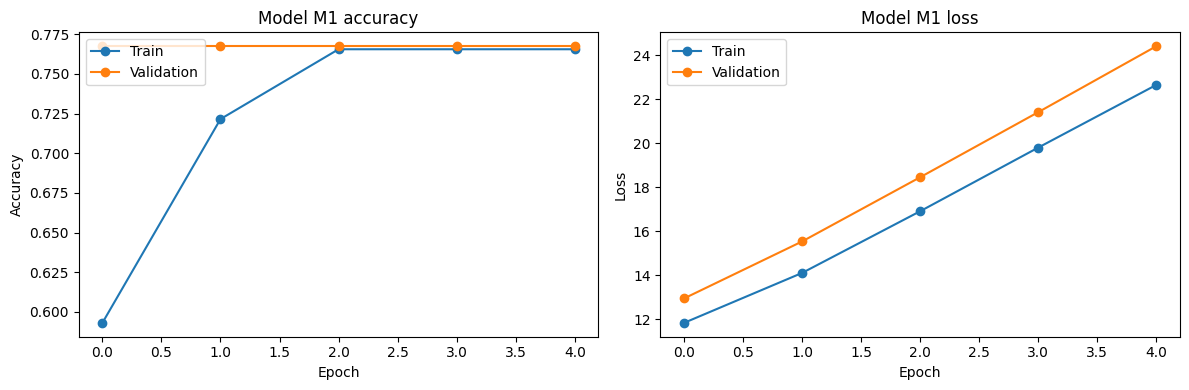

In [ ]:
with open(base_path+'/model/categorical_history_M1.pkl', 'rb') as file:
    history_M1 = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_M1['accuracy'], marker='o')
plt.plot(history_M1['val_accuracy'], marker='o')
plt.title('Model M1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_M1['loss'], marker='o')
plt.plot(history_M1['val_loss'], marker='o')
plt.title('Model M1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()



### 4.3 Model M2

In [ ]:
# LSTM Model
M2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                              weights=[embedding_matrix], trainable=False),
    LSTM(256, return_sequences=True),
    LSTM(256),
    Dense(output, activation='softmax')
])

In [ ]:
M2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,000 (125.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 32,000 (125.00 KB)

In [ ]:
M2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the model
M2.compile(optimizer=M2_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_M2= M2.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3854s 17s/step - accuracy: 0.6201 - loss: 14.6830 - val_accuracy: 0.7671 - val_loss: 18.5656
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3766s 17s/step - accuracy: 0.7632 - loss: 19.7700 - val_accuracy: 0.7675 - val_loss: 24.6514
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3831s 17s/step - accuracy: 0.7701 - loss: 25.5120 - val_accuracy: 0.7675 - val_loss: 30.2889
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3830s 17s/step - accuracy: 0.7624 - loss: 31.6961 - val_accuracy: 0.7675 - val_loss: 36.5261
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3794s 17s/step - accuracy: 0.7598 - loss: 38.4128 - val_accuracy: 0.7675 - val_loss: 43.5762


In [ ]:
M2.save(base_path+'/model/categorical_M2.h5')

In [ ]:
with open(base_path+'/model/categorical_history_M2.pkl', 'wb') as file:
    pickle.dump(history_M2.history, file)

### 4.4 Output M2

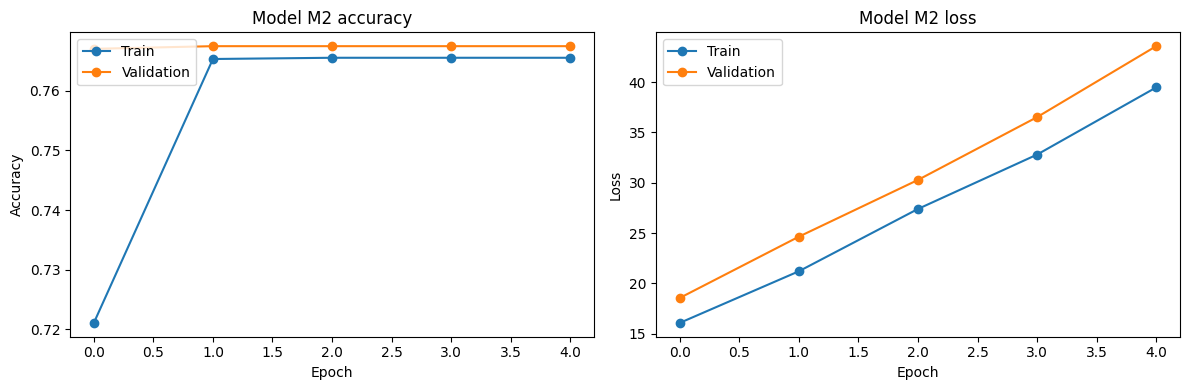

In [ ]:
with open(base_path+'/model/categorical_history_M2.pkl', 'rb') as file:
    history_M2 = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_M2['accuracy'], marker='o')
plt.plot(history_M2['val_accuracy'], marker='o')
plt.title('Model M2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_M2['loss'], marker='o')
plt.plot(history_M2['val_loss'], marker='o')
plt.title('Model M2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()


### 4.5 Model M3


In [ ]:
# LSTM Model
M3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                              weights=[embedding_matrix], trainable=False),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(output, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
M3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,000 (125.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 32,000 (125.00 KB)

In [ ]:
M3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the model
M3.compile(optimizer=M3_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_M3= M3.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.7671 - loss: 11.5155 - val_accuracy: 0.7675 - val_loss: 10.6522
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.7661 - loss: 10.8876 - val_accuracy: 0.7675 - val_loss: 11.7540
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.7639 - loss: 11.9417 - val_accuracy: 0.7675 - val_loss: 13.0484
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.7616 - loss: 13.1885 - val_accuracy: 0.7675 - val_loss: 14.2425
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - accuracy: 0.7582 - loss: 14.3810 - val_accuracy: 0.7675 - val_loss: 15.5243


In [ ]:
M3.save(base_path+'/model/categorical_M3.h5')

In [ ]:
with open(base_path+'/model/categorical_history_M3.pkl', 'wb') as file:
    pickle.dump(history_M3.history, file)

### 4.6 Output M3

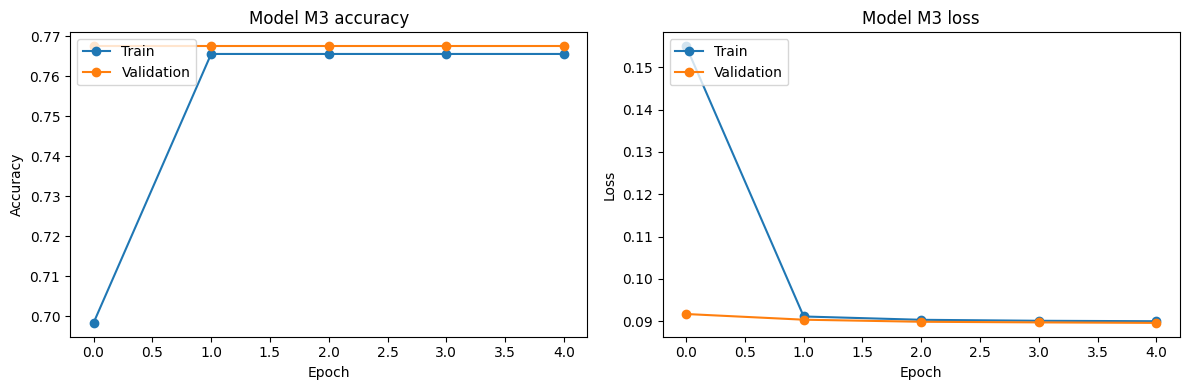

In [ ]:
with open(base_path+'/model/history_M3.pkl', 'rb') as file:
    history_M3 = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_M3['accuracy'], marker='o')
plt.plot(history_M3['val_accuracy'], marker='o')
plt.title('Model M3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_M3['loss'], marker='o')
plt.plot(history_M3['val_loss'], marker='o')
plt.title('Model M3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()

### 4.7 Model M4


In [ ]:
# LSTM Model
M4 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                              weights=[embedding_matrix], trainable=True),
    LSTM(64, return_sequences=True),
    LSTM(128),
    Dense(output, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
M4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,000 (62.50 KB)

 Trainable params: 16,000 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
M4_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Compile the model
M4.compile(optimizer=M4_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_M4= M4.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1052s 5s/step - accuracy: 0.7534 - loss: 11.2389 - val_accuracy: 0.7675 - val_loss: 12.1386
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1028s 5s/step - accuracy: 0.7651 - loss: 12.7609 - val_accuracy: 0.7675 - val_loss: 14.9967
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1048s 5s/step - accuracy: 0.7610 - loss: 15.2659 - val_accuracy: 0.7675 - val_loss: 17.6143
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - accuracy: 0.7663 - loss: 18.1784 - val_accuracy: 0.7675 - val_loss: 20.2469
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 1099s 5s/step - accuracy: 0.7622 - loss: 20.6790 - val_accuracy: 0.7675 - val_loss: 23.0992


In [ ]:
M4.save(base_path+'/model/categorical_M4.h5')

In [ ]:
with open(base_path+'/model/categorical_history_M4.pkl', 'wb') as file:
    pickle.dump(history_M4.history, file)

### 4.8 Output M4

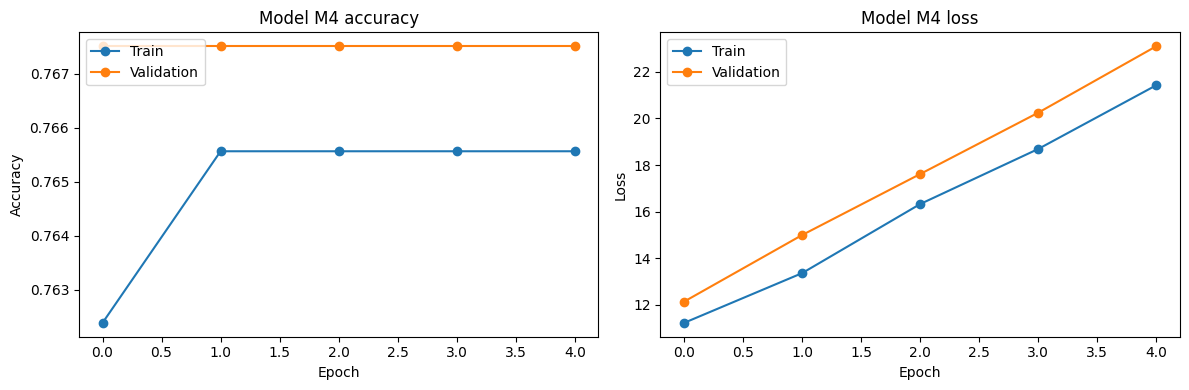

In [ ]:
with open(base_path+'/model/categorical_history_M4.pkl', 'rb') as file:
    history_M4 = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_M4['accuracy'], marker='o')
plt.plot(history_M4['val_accuracy'], marker='o')
plt.title('Model M4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_M4['loss'], marker='o')
plt.plot(history_M4['val_loss'], marker='o')
plt.title('Model M4 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()


###4.9 Model M5

In [ ]:
# LSTM Model
M5 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                              weights=[embedding_matrix], trainable=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(output, activation='softmax')
])

In [ ]:
M5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,000 (62.50 KB)

 Trainable params: 16,000 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
M5_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
M5.compile(optimizer=M5_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_M5= M5.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.7612 - loss: 10.7881 - val_accuracy: 0.7675 - val_loss: 10.1572
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.7645 - loss: 10.3368 - val_accuracy: 0.7675 - val_loss: 11.2065
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.7601 - loss: 11.2430 - val_accuracy: 0.7675 - val_loss: 12.2492
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.7644 - loss: 12.5167 - val_accuracy: 0.7675 - val_loss: 13.4412
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.7619 - loss: 13.5899 - val_accuracy: 0.7675 - val_loss: 14.5725


In [ ]:
M5.save(base_path+'/model/categorical_M5.h5')

In [ ]:
with open(base_path+'/model/categorical_history_M5.pkl', 'wb') as file:
    pickle.dump(history_M5.history, file)

### 4.10 Output M5

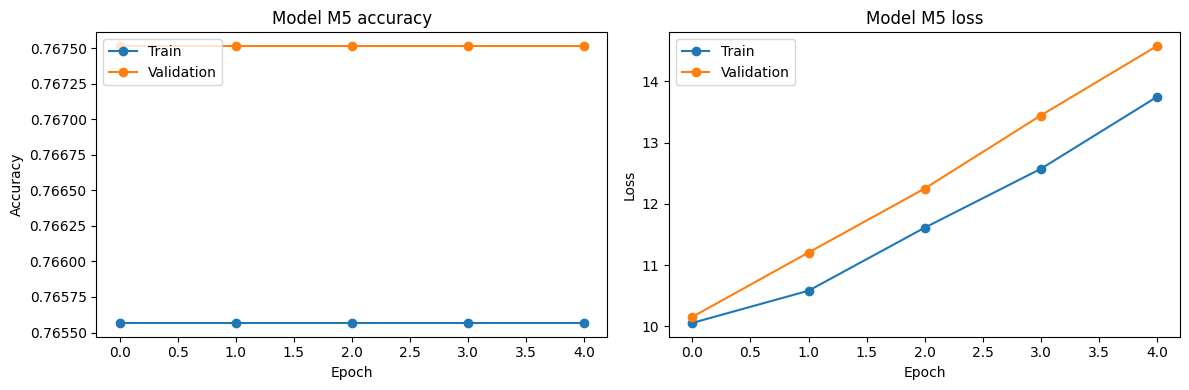

In [ ]:
with open(base_path+'/model/categorical_history_M5.pkl', 'rb') as file:
    history_M5 = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_M5['accuracy'], marker='o')
plt.plot(history_M5['val_accuracy'], marker='o')
plt.title('Model M5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_M5['loss'], marker='o')
plt.plot(history_M5['val_loss'], marker='o')
plt.title('Model M5 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()

## 5.ROUGE

In [ ]:
# Load test data
test_df = pd.read_csv(base_path + '/fill_test.csv')
test_sentences=test_df['news_text'].tolist()

In [ ]:
test_sentences_lower = test_df['Sum_text'].str.lower().tolist()

In [ ]:
test_df.head()

category                                        gold_labels  \
0  tajuk utama  {"0": [true, true], "1": [false], "2": [true],...   
1      showbiz  {"0": [true], "1": [false], "2": [true], "3": ...   
2      showbiz  {"0": [true, true], "1": [true], "2": [false],...   
3    teknologi  {"0": [true, false], "1": [true, true, true], ...   
4     olahraga  {"0": [true], "1": [true, true], "2": [false, ...   

                                                  id  \
0  1489771800-dua-wni-lolos-hukuman-mati-di-arab-...   
1  1502417986-ibu-taylor-swift-sakit-hati-anaknya...   
2  1518811200-kanye-west-kembali-ke-instagram-fan...   
3  1512173700-startup-fintech-lending-awantunai-r...   
4  1496783700-petrucci-saya-minta-maaf-ke-valenti...   

                                          paragraphs          source  \
0  {"0": ["Jakarta , CNN Indonesia - - Dua warga ...   cnn indonesia   
1  {"0": ["Jakarta , CNN Indonesia - - Ibunda Tay...   cnn indonesia   
2  {"0": ["Jakarta , CNN Indonesia - - Kanye West...   cnn indonesia   
3  {"0": ["Startup fintech yang bergerak di bidan...  dailysocial.id   
4  {"0": ["Jakarta , CNN Indonesia - - Pebalap Pr...   cnn indonesia   

                                          source_url  \
0  http://www.cnnindonesia.com/internasional/2017...   
1  https://www.cnnindonesia.com/hiburan/201708100...   
2  https://www.cnnindonesia.com/hiburan/201802152...   
3  https://dailysocial.id/post/startup-fintech-le...   
4  http://www.cnnindonesia.com/olahraga/201706051...   

                                             summary  \
0  {"0": "Dua warga negara Indonesia di Arab Saud...   
1  {"0": "Ibunda Taylor Swift , Andrea Smith , me...   
2  {"0": "Kanye West kembali ke media sosial deng...   
3  {"0": "Startup fintech yang bergerak di bidang...   
4  {"0": "Pebalap Pramac Ducati , Danilo Petrucci...   

                                           news_text  num_of_paragraphs  \
0  Jakarta , CNN Indonesia - - Dua warga negara I...                 18   
1  Jakarta , CNN Indonesia - - Ibunda Taylor Swif...                 16   
2  Jakarta , CNN Indonesia - - Kanye West kembali...                 14   
3  Startup fintech yang bergerak di bidang   lend...                 15   
4  Jakarta , CNN Indonesia - - Pebalap Pramac Duc...                  9   

                                        summary_text  num_of_summary  \
0  Dua warga negara Indonesia di Arab Saudi terbe...               3   
1  Ibunda Taylor Swift , Andrea Smith , mengungka...               2   
2  Kanye West kembali ke media sosial dengan akun...               3   
3  Startup fintech yang bergerak di bidang lendin...               4   
4  Pebalap Pramac Ducati , Danilo Petrucci , mint...               3   

   len_sentence                                             labels  \
0            29  [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1            22  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2            21  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3            32  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4            24  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

   labels_length  
0             29  
1             22  
2             21  
3             32  
4             24

from matplotlib import pyplot as plt
_df_0['num_of_paragraphs'].plot(kind='hist', bins=20, title='num_of_paragraphs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['num_of_summary'].plot(kind='hist', bins=20, title='num_of_summary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['len_sentence'].plot(kind='hist', bins=20, title='len_sentence')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['labels_length'].plot(kind='hist', bins=20, title='labels_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('gold_labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('paragraphs').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='num_of_paragraphs', y='num_of_summary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='num_of_summary', y='len_sentence', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='len_sentence', y='labels_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['num_of_paragraphs'].plot(kind='line', figsize=(8, 4), title='num_of_paragraphs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['num_of_summary'].plot(kind='line', figsize=(8, 4), title='num_of_summary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['len_sentence'].plot(kind='line', figsize=(8, 4), title='len_sentence')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['labels_length'].plot(kind='line', figsize=(8, 4), title='labels_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['gold_labels'].value_counts()
    for x_label, grp in _df_15.groupby('category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('category')
_ = plt.ylabel('gold_labels')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['id'].value_counts()
    for x_label, grp in _df_16.groupby('gold_labels')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gold_labels')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['paragraphs'].value_counts()
    for x_label, grp in _df_17.groupby('id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('id')
_ = plt.ylabel('paragraphs')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['source'].value_counts()
    for x_label, grp in _df_18.groupby('paragraphs')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('paragraphs')
_ = plt.ylabel('source')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='num_of_paragraphs', y='category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['gold_labels'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='num_of_paragraphs', y='gold_labels', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='num_of_paragraphs', y='id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['paragraphs'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='num_of_paragraphs', y='paragraphs', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

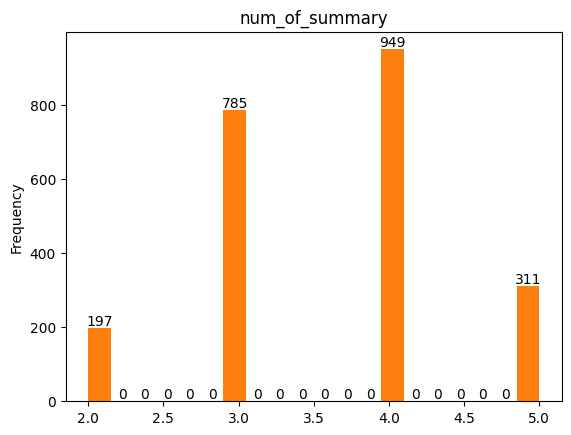

In [ ]:
# @title num_of_summary

ax = test_df['num_of_summary'].plot(kind='hist', bins=20, title='num_of_summary')

# Customize the spines to make them visible
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Get the counts and the edges of the bins
counts, bins, patches = ax.hist(test_df['num_of_summary'], bins=20)

# Loop over the patches (bars) to add text annotations with the exact count
for count, patch in zip(counts, patches):
    # Get the x and y positions for the annotation
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    # Add text annotation to the plot
    ax.text(x, y, int(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [ ]:
print(test_sentences)

['[\'suara.com - kecemasan berlebihan yang dialami zayn malik ternyata belum hilang total .\', \'terbukti , setelah london , dia sekarang membatalkan penampilannya di dubai dengan alasan penyakit mentalnya \\xa0 kambuh .\', \'dilansir dari laman nme , pengumuman pembatalan konser ini disampaikan promotor yang mengutip pesan dari zayn .\', \'" saya sudah berjuang selama tiga bulan untuk mengatasi kecemasan ini .\', \'sudah ada kemajuan , tapi saya belum merasa percaya diri untuk tampil di dubai seperti yang sudah direncanakan pada oktober nanti , " bunyi pernyataan tersebut .\', \'zayn memang tengah menjalani promo single pertamanya , pillowtalk sebagai solois sejak hengkang dari one direction .\', \'debutnya sebagai solois terbilang moncer .\', \'album pertamanya bertajuk mind of mine yang dirilis pada 25 maret lalu juga menoreh prestasi .\', \'album itu menjadi album pertama milik solois lelaki asal inggris yang menjadi nomor satu di amerika serikat .\']', "['merdeka.com - penguin men

In [ ]:
test_df[['news_text','label', 'summary_text']].head()

news_text  \
0  Suara.com - Kecemasan berlebihan yang dialami ...   
1  Merdeka.com - Penguin menjadi salah satu hewan...   
2  Jakarta , CNN Indonesia - - Pabrikan otomotif ...   
3  Galatasaray dikabarkan sudah mulai berancang -...   
4  Moskow ( ANTARA News ) - Rusia pada Kamis bers...   

                            label  \
0     [1, 1, 0, 1, 1, 0, 0, 0, 0]   
1     [1, 0, 0, 1, 1, 1, 0, 0, 0]   
2  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]   
3        [1, 1, 1, 0, 0, 0, 0, 0]   
4        [1, 1, 0, 0, 0, 0, 0, 0]   

                                        summary_text  
0  Kecemasan berlebihan yang dialami Zayn Malik t...  
1  Penguin menjadi salah satu hewan yang memiliki...  
2  Pabrikan otomotif asal China , Wuling akan seg...  
3  Kabarnya , Galatasaray tengah berancang - anca...  
4  Kamis , negara Rusia bersikukuh tetap membloki...

In [ ]:
test_df['labels'].head()

0    [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, dtype: object

In [ ]:
#model='categorical_M1'
model='categorical_M2'
#model='categorical_M3'
#model='categorical_M4'
#model='categorical_M5'

test_df = test_df = pd.read_csv(base_path + '/fill_test.csv')
test_sentences=test_df['news_text'].tolist()

In [ ]:
print(model)

### Generator model

In [ ]:
max_len = 1319
embedding_dim =128
vocab_size = 250
# Specify the path where you want to save the model
skipGram_path = base_path+"/skipgram/skipgram.model"

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
w2v_model = Word2Vec.load(skipGram_path)

In [ ]:
w2v_vocab = {word: idx + 1 for idx, word in enumerate(w2v_model.wv.index_to_key[:vocab_size - 1])}

In [ ]:
def tokenize_and_convert_to_sequences(sentences, w2v_vocab):
    sequences = []
    for sentence in sentences:
        tokenized = word_tokenize(sentence.lower())
        sequence = [w2v_vocab.get(word, 0) for word in tokenized]
        sequences.append(sequence)
    return sequences

In [ ]:
Model=tf.keras.models.load_model(base_path+'/model/'+model+'.h5')

In [ ]:


# Assuming these functions are defined elsewhere in your code
# tokenize_and_convert_to_sequences(sentences, w2v_vocab)
# Model.predict(padded_sequences)

summaries = []
gen_indices = []

for doc in test_sentences:
    sentences = sent_tokenize(doc)  # Split document into sentences
    sequences = tokenize_and_convert_to_sequences(sentences, w2v_vocab)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Make predictions
    if len(padded_sequences) == 0:
        summaries.append('')
        continue

    predictions = Model.predict(padded_sequences)

    # Debugging: Print the number of sentences and predictions
    print(f"Number of sentences: {len(sentences)}")
    print(f"Predictions shape: {predictions.shape}")

    # Determine the number of sentences to include in the summary
    num_sentences = len(sentences)
    num_top_sentences = max(1,  int(np.round(0.3 * num_sentences)) ) # Ensure at least one sentence is included


     # Adjusting the sorting mechanism
    predictions = np.array(predictions).flatten()

    # Ensure the top indices are unique and handle repetitive predictions
    top_indices = np.argpartition(predictions, -num_top_sentences)[-num_top_sentences:]
    top_indices = top_indices[np.argsort(-predictions[top_indices])]
    top_indices = list(set([int(idx/75) for idx in top_indices]))  # Ensure indices are unique

    if len(top_indices) < num_top_sentences:
        # If unique indices are fewer than required, add additional unique indices
        remaining_indices = list(set(range(len(sentences))) - set(top_indices))
        np.random.shuffle(remaining_indices)
        top_indices.extend(remaining_indices[:num_top_sentences - len(top_indices)])

    # Ensure the final indices are within the valid range and sorted
    top_indices = sorted([idx for idx in top_indices if idx < num_sentences])

    # Debugging: Print the top indices
    top_indices.sort()
    print(f"Top indices: {top_indices}")

    gen_indices.append(top_indices)

    # Generate summary by selecting top sentences
    summary = ' '.join([sentences[idx] for idx in top_indices if idx < num_sentences])
    summaries.append(summary)

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 25
Predictions shape: (25, 75)
Top indices: [0, 2, 10, 11, 12, 15, 17, 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 26
Predictions shape: (26, 75)
Top indices: [1, 4, 5, 19, 20, 22, 24, 25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Number of sentences: 22
Predictions shape: (22, 75)
Top indices: [12, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 20
Predictions shape: (20, 75)
Top indices: [1, 11, 16, 17, 18, 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 22
Predictions shape: (22, 75)
Top indices: [12, 16, 17, 18, 19, 20, 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 24
Predictions shape: (24, 75)
Top indices: [0, 6, 10, 11, 12, 15, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 25
Predictions shape: (25, 75)
Top indices: [0, 2, 10, 11, 12, 15, 17, 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/st

In [ ]:
# Assign summaries to test_df if lengths match
if len(summaries) == len(test_sentences):
    test_df['generated_summary'] = summaries
else:
    print("Error: Number of summaries does not match number of test sentences.")

# Now test_df['generated_summary'] should contain the generated summaries

In [ ]:
# Regular expression pattern
#pattern = r'\\xa0|\b(?:Jakarta\s*,\s*CNN\s*Indonesia\s*-\s*-|Berlin\s*\(\s*ANTARA\s*News\s*\)\s*–|Vientiane\s*\(\s*ANTARA\s*News\s*\)\s*-\s*|\w+\.com\s*-\s*|\w+\.id\s*:\s*|KOREA SELATAN\s*–)\b|simak juga\s*:|Jakarta \( ANTARA News \) -\s*'

# Function to replace matched strings with an empty string
#test_df['generated_summary'] = test_df['generated_summary'].apply(lambda x: re.sub(pattern, '', x, flags=re.IGNORECASE))


In [ ]:
print(summaries)

['Upaya pembebasan dilakukan oleh Konsulat Jenderal RI di Jeddah dan Kedutaan Besar RI di Riyadh , " kata Direktur Perlindungan WNI dan Badan Hukum Indonesia Kementerian Luar Negeri Iqbal Lalu Muhammad dalam keterangan tertulis , Kamis ( 16 / 3 ) . Namun hakim menunda untuk kembali mendengarkan keterangan para saksi . Penundaan ini dimanfaatkan oleh Tim Perlindungan WNI untuk melakukan pendekatan kepada ayah korban agar memaafkan Masamah . Alhamdulillah ada hasilnya , " kata pejabat konsuler KJRI Jeddah Rahmat Aming . Meskipun Mimin sudah dibebaskan , KBRI berencana akan mengajukan gugatan kompensasi kepada penuntut karena telah menyebabkan Mimin mendekam di penjara selama 5 tahun tanpa bukti yang kuat . Mimin sendiri saat ini sudah dipulangkan dan tiba kemarin di Jakarta . Dalam catatan Kemenlu , saat ini masih terdapat 19 WNI terancam hukuman mati di Arab Saudi . Terdiri adari 14 WNI terjerat kasus , empat orang terjerat kasus zina dan satu orang terjerat kasus sihir . Tahun lalu , p

In [ ]:
test_df[['generated_summary','summary_text']].head()


generated_summary  \
0  Upaya pembebasan dilakukan oleh Konsulat Jende...   
1  Mueller mengatakan Swift mengarang cerita dan ...   
2  Setelahnya , ia mengunggah sejumlah foto pasan...   
3  Startup fintech yang bergerak di bidang   lend...   
4  Jakarta , CNN Indonesia - - Pebalap Pramac Duc...   

                                        summary_text  
0  Dua warga negara Indonesia di Arab Saudi terbe...  
1  Ibunda Taylor Swift , Andrea Smith , mengungka...  
2  Kanye West kembali ke media sosial dengan akun...  
3  Startup fintech yang bergerak di bidang lendin...  
4  Pebalap Pramac Ducati , Danilo Petrucci , mint...

In [ ]:
def find_indices(row):
    indices = [index for index, value in enumerate(row) if value == 1]
    return indices


In [ ]:

test_df['labels'] = test_df['labels'].apply(ast.literal_eval)
# Apply function to each row

test_df['label_indices'] = test_df['labels'].apply(find_indices)

In [ ]:
test_df['generated_indices']=gen_indices

In [ ]:
# Initialize Rouge
rouge = Rouge()

In [ ]:
# Filter out empty summaries for ROUGE score calculation
non_empty_df = test_df[test_df['generated_summary'] != '']

In [ ]:
# Calculate Rouge scores
rouge_scores = rouge.get_scores(non_empty_df['generated_summary'], non_empty_df['summary_text'], avg=True)
individual_rouge_scores = rouge.get_scores(non_empty_df['generated_summary'], non_empty_df['summary_text'], avg=False)


In [ ]:
flattened_scores = []

In [ ]:

for score in individual_rouge_scores:
    flattened = {f"{metric}_{key}": value for metric, results in score.items() for key, value in results.items()}
    flattened_scores.append(flattened)

In [ ]:
 individual_rouge_df=pd.DataFrame(flattened_scores)

In [ ]:
test_df = pd.concat([test_df.reset_index(drop=True), individual_rouge_df.reset_index(drop=True)], axis=1)


In [ ]:
test_df.head()

In [ ]:
# Extracting Rouge-1 and Rouge-2 scores with precision, recall, and f1_score
rouge_1_scores = rouge_scores['rouge-1']
rouge_2_scores = rouge_scores['rouge-2']

# Display the results
print("Rouge-1 Scores:")
print("Precision:", rouge_1_scores['p'])
print("Recall:", rouge_1_scores['r'])
print("F1 Score:", rouge_1_scores['f'])

print("\nRouge-2 Scores:")
print("Precision:", rouge_2_scores['p'])
print("Recall:", rouge_2_scores['r'])
print("F1 Score:", rouge_2_scores['f'])

In [ ]:
with open(base_path+'/model/'+model+'_rouge_scores.json', 'w') as f:
    json.dump(rouge_scores, f)

In [ ]:
test_df.to_csv(base_path+'/model/'+model+'_test_output.csv', index=False)

In [ ]:
print(base_path+'/model/'+model+'_test_output.csv')

### Model len var

In [ ]:
#model='categorical_M1'
model='categorical_M2'
#model='categorical_M3'
#model='categorical_M4'
#model='categorical_M5'
#Len='Len'

In [ ]:
test_df = pd.read_csv(base_path+'/fill_test.csv')
test_sentences=test_df['news_text'].tolist()
test_top_indices = test_df['labels'].apply(ast.literal_eval).apply(lambda x: x.count(1)).tolist()

In [ ]:
print(test_top_indices)

[5, 2, 3, 4, 3, 4, 3, 3, 5, 4, 5, 5, 4, 3, 4, 3, 4, 5, 4, 2, 3, 4, 3, 5, 3, 4, 5, 4, 2, 4, 4, 2, 3, 3, 2, 4, 4, 5, 5, 4, 3, 3, 3, 3, 2, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 3, 2, 4, 5, 4, 4, 3, 3, 4, 2, 4, 4, 4, 2, 3, 5, 3, 3, 3, 2, 3, 4, 3, 4, 4, 4, 4, 5, 4, 3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 5, 3, 3, 5, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 3, 5, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 5, 4, 3, 2, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 2, 4, 3, 4, 4, 3, 4, 4, 3, 2, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 5, 2, 4, 4, 3, 5, 6, 3, 3, 3, 3, 5, 4, 3, 5, 4, 4, 3, 4, 4, 3, 3, 4, 5, 3, 4, 4, 5, 5, 2, 4, 2, 4, 4, 3, 3, 2, 3, 4, 4, 3, 3, 5, 4, 4, 3, 3, 6, 3, 4, 2, 2, 4, 3, 4, 4, 2, 3, 4, 4, 3, 5, 2, 4, 4, 5, 3, 5, 4, 4, 4, 3, 5, 3, 3, 2, 3, 3, 4, 3, 3, 5, 2, 3, 5, 4, 4, 4, 2, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 2, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 5, 4, 2, 3, 4, 4, 5, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 2, 4, 3, 5, 3, 5, 4, 2, 5, 3, 3, 

In [ ]:
print(model)

categorical_M2


### Generator model len

In [ ]:
max_len = 1319
embedding_dim = 128
vocab_size = 250
# Specify the path where you want to save the model
skipGram_path = base_path+"/skipgram/skipgram.model"

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
w2v_model = Word2Vec.load(skipGram_path)

In [ ]:
w2v_vocab = {word: idx + 1 for idx, word in enumerate(w2v_model.wv.index_to_key[:vocab_size - 1])}

In [ ]:
def tokenize_and_convert_to_sequences(sentences, w2v_vocab):
    sequences = []
    for sentence in sentences:
        tokenized = word_tokenize(sentence.lower())
        sequence = [w2v_vocab.get(word, 0) for word in tokenized]
        sequences.append(sequence)
    return sequences

In [ ]:
Model=tf.keras.models.load_model(base_path+'/model/'+model+'.h5')

In [ ]:


# Assuming these functions are defined elsewhere in your code
# tokenize_and_convert_to_sequences(sentences, w2v_vocab)
# Model.predict(padded_sequences)

summaries = []
gen_indices = []

for doc, top_sentences in zip(test_sentences, test_top_indices):
    sentences = sent_tokenize(doc)  # Split document into sentences
    sequences = tokenize_and_convert_to_sequences(sentences, w2v_vocab)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Make predictions
    if len(padded_sequences) == 0:
        summaries.append('')
        continue

    predictions = Model.predict(padded_sequences)

    # Debugging: Print the number of sentences and predictions
    print(f"Number of sentences: {len(sentences)}")
    print(f"Predictions shape: {predictions.shape}")

    # Handle cases where there are fewer than 4 sentences
    num_sentences = len(sentences)
    num_top_sentences = min(top_sentences, num_sentences)

# Adjusting the sorting mechanism
    predictions = np.array(predictions).flatten()

    # Ensure the top indices are unique and handle repetitive predictions
    top_indices = np.argpartition(predictions, -num_top_sentences)[-num_top_sentences:]
    top_indices = top_indices[np.argsort(-predictions[top_indices])]
    top_indices = list(set([int(idx/75) for idx in top_indices]))  # Ensure indices are unique

    if len(top_indices) < num_top_sentences:
        # If unique indices are fewer than required, add additional unique indices
        remaining_indices = list(set(range(len(sentences))) - set(top_indices))
        np.random.shuffle(remaining_indices)
        top_indices.extend(remaining_indices[:num_top_sentences - len(top_indices)])

    # Ensure the final indices are within the valid range and sorted
    top_indices = sorted([idx for idx in top_indices if idx < num_sentences])

    # Debugging: Print the top indices
    top_indices.sort()
    print(f"Top indices: {top_indices}")

    gen_indices.append(top_indices)
    # Generate summary by selecting top sentences
    summary = ' '.join([sentences[idx] for idx in top_indices if idx < num_sentences])
    summaries.append(summary)

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Number of sentences: 25
Predictions shape: (25, 75)
Top indices: [0, 17, 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 26
Predictions shape: (26, 75)
Top indices: [4, 19, 24, 25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 22
Predictions shape: (22, 75)
Top indices: [16, 17, 18, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 20
Predictions shape: (20, 75)
Top indices: [16, 17, 18, 19]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 22
Predictions shape: (22, 75)
Top indices: [16, 17, 18, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 24
Predictions shape: (24, 75)
Top indices: [0, 15, 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Number of sentences: 25
Predictions shape: (25, 75)
Top indices: [0, 24]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Number of sentences: 25
Predictions shape: (25, 75)
Top indices: [0, 15, 17, 24]
1/1 ━━━━━━━━━━━━━━

In [ ]:
# Assign summaries to test_df if lengths match
if len(summaries) == len(test_sentences):
    test_df['generated_summary'] = summaries
else:
    print("Error: Number of summaries does not match number of test sentences.")

# Now test_df['generated_summary'] should contain the generated summaries

In [ ]:
# Regular expression pattern
#pattern = r'\\xa0|\b(?:Jakarta\s*,\s*CNN\s*Indonesia\s*-\s*-|Berlin\s*\(\s*ANTARA\s*News\s*\)\s*–|Vientiane\s*\(\s*ANTARA\s*News\s*\)\s*-\s*|\w+\.com\s*-\s*|\w+\.id\s*:\s*|KOREA SELATAN\s*–)\b|simak juga\s*:|Jakarta \( ANTARA News \) -\s*'

# Function to replace matched strings with an empty string
#test_df['generated_summary'] = test_df['generated_summary'].apply(lambda x: re.sub(pattern, '', x, flags=re.IGNORECASE))


In [ ]:
print(summaries)

['Meskipun Mimin sudah dibebaskan , KBRI berencana akan mengajukan gugatan kompensasi kepada penuntut karena telah menyebabkan Mimin mendekam di penjara selama 5 tahun tanpa bukti yang kuat . Mimin sendiri saat ini sudah dipulangkan dan tiba kemarin di Jakarta . Dalam catatan Kemenlu , saat ini masih terdapat 19 WNI terancam hukuman mati di Arab Saudi . Terdiri adari 14 WNI terjerat kasus , empat orang terjerat kasus zina dan satu orang terjerat kasus sihir . Tahun lalu , pemerintah berhasil membeaskan tujuh WNI berhasil yang terancam hukuman mati di Arab Saudi .', 'Swift telah datang ke persidangan yang telah digelar sejak Senin ( 7 / 8 ) lalu dengan jalur yang tidak diketahui untuk menghindari bertemu dengan wartawan yang menunggu di luar gedung persidangan . Ia diminta oleh panitia untuk ikut mengantre bersama Swifties yang masih remaja dan ibu mereka .', 'Kala itu , Kanye membatalkan sisa pertunjukkan turnya itu lantaran menderita kelelahan akut . Ia membatalkan 23 konser yang ters

In [ ]:
test_df[['generated_summary','summary_text']].head()


generated_summary  \
0  Meskipun Mimin sudah dibebaskan , KBRI berenca...   
1  Swift telah datang ke persidangan yang telah d...   
2  Kala itu , Kanye membatalkan sisa pertunjukkan...   
3  Ke depannya , perusahaan akan diperluas untuk ...   
4  Jakarta , CNN Indonesia - - Pebalap Pramac Duc...   

                                        summary_text  
0  Dua warga negara Indonesia di Arab Saudi terbe...  
1  Ibunda Taylor Swift , Andrea Smith , mengungka...  
2  Kanye West kembali ke media sosial dengan akun...  
3  Startup fintech yang bergerak di bidang lendin...  
4  Pebalap Pramac Ducati , Danilo Petrucci , mint...

In [ ]:
def find_indices(row):
    indices = [index for index, value in enumerate(row) if value == 1]
    return indices


In [ ]:

test_df['labels'] = test_df['labels'].apply(ast.literal_eval)
# Apply function to each row

test_df['label_indices'] = test_df['labels'].apply(find_indices)

In [ ]:
test_df['generated_indices']=gen_indices

In [ ]:
# Initialize Rouge
rouge = Rouge()

In [ ]:
# Filter out empty summaries for ROUGE score calculation
non_empty_df = test_df[test_df['generated_summary'] != '']

In [ ]:
# Calculate Rouge scores
rouge_scores = rouge.get_scores(non_empty_df['generated_summary'], non_empty_df['summary_text'], avg=True)
individual_rouge_scores = rouge.get_scores(non_empty_df['generated_summary'], non_empty_df['summary_text'], avg=False)


In [ ]:
flattened_scores = []

In [ ]:

for score in individual_rouge_scores:
    flattened = {f"{metric}_{key}": value for metric, results in score.items() for key, value in results.items()}
    flattened_scores.append(flattened)

In [ ]:
 individual_rouge_df=pd.DataFrame(flattened_scores)

In [ ]:
test_df = pd.concat([test_df.reset_index(drop=True), individual_rouge_df.reset_index(drop=True)], axis=1)


In [ ]:
test_df.head()

category                                        gold_labels  \
0  tajuk utama  {"0": [true, true], "1": [false], "2": [true],...   
1      showbiz  {"0": [true], "1": [false], "2": [true], "3": ...   
2      showbiz  {"0": [true, true], "1": [true], "2": [false],...   
3    teknologi  {"0": [true, false], "1": [true, true, true], ...   
4     olahraga  {"0": [true], "1": [true, true], "2": [false, ...   

                                                  id  \
0  1489771800-dua-wni-lolos-hukuman-mati-di-arab-...   
1  1502417986-ibu-taylor-swift-sakit-hati-anaknya...   
2  1518811200-kanye-west-kembali-ke-instagram-fan...   
3  1512173700-startup-fintech-lending-awantunai-r...   
4  1496783700-petrucci-saya-minta-maaf-ke-valenti...   

                                          paragraphs          source  \
0  {"0": ["Jakarta , CNN Indonesia - - Dua warga ...   cnn indonesia   
1  {"0": ["Jakarta , CNN Indonesia - - Ibunda Tay...   cnn indonesia   
2  {"0": ["Jakarta , CNN Indonesia - - Kanye West...   cnn indonesia   
3  {"0": ["Startup fintech yang bergerak di bidan...  dailysocial.id   
4  {"0": ["Jakarta , CNN Indonesia - - Pebalap Pr...   cnn indonesia   

                                          source_url  \
0  http://www.cnnindonesia.com/internasional/2017...   
1  https://www.cnnindonesia.com/hiburan/201708100...   
2  https://www.cnnindonesia.com/hiburan/201802152...   
3  https://dailysocial.id/post/startup-fintech-le...   
4  http://www.cnnindonesia.com/olahraga/201706051...   

                                             summary  \
0  {"0": "Dua warga negara Indonesia di Arab Saud...   
1  {"0": "Ibunda Taylor Swift , Andrea Smith , me...   
2  {"0": "Kanye West kembali ke media sosial deng...   
3  {"0": "Startup fintech yang bergerak di bidang...   
4  {"0": "Pebalap Pramac Ducati , Danilo Petrucci...   

                                           news_text  num_of_paragraphs  \
0  Jakarta , CNN Indonesia - - Dua warga negara I...                 18   
1  Jakarta , CNN Indonesia - - Ibunda Taylor Swif...                 16   
2  Jakarta , CNN Indonesia - - Kanye West kembali...                 14   
3  Startup fintech yang bergerak di bidang   lend...                 15   
4  Jakarta , CNN Indonesia - - Pebalap Pramac Duc...                  9   

                                        summary_text  ...  \
0  Dua warga negara Indonesia di Arab Saudi terbe...  ...   
1  Ibunda Taylor Swift , Andrea Smith , mengungka...  ...   
2  Kanye West kembali ke media sosial dengan akun...  ...   
3  Startup fintech yang bergerak di bidang lendin...  ...   
4  Pebalap Pramac Ducati , Danilo Petrucci , mint...  ...   

      generated_indices  rouge-1_r rouge-1_p  rouge-1_f rouge-2_r rouge-2_p  \
0  [24, 25, 26, 27, 28]   0.312500  0.241935   0.272727  0.050847  0.038462   
1              [17, 20]   0.129630  0.175000   0.148936  0.000000  0.000000   
2          [18, 19, 20]   0.152174  0.241379   0.186667  0.000000  0.000000   
3      [26, 27, 30, 31]   0.125000  0.132075   0.128440  0.015385  0.014925   
4           [0, 15, 20]   0.591837  0.725000   0.651685  0.500000  0.580000   

  rouge-2_f  rouge-l_r  rouge-l_p  rouge-l_f  
0  0.043796   0.208333   0.161290   0.181818  
1  0.000000   0.129630   0.175000   0.148936  
2  0.000000   0.130435   0.206897   0.160000  
3  0.015152   0.125000   0.132075   0.128440  
4  0.537037   0.571429   0.700000   0.629213  

[5 rows x 26 columns]

In [ ]:
# Extracting Rouge-1 and Rouge-2 scores with precision, recall, and f1_score
rouge_1_scores = rouge_scores['rouge-1']
rouge_2_scores = rouge_scores['rouge-2']

# Display the results
print("Rouge-1 Scores:")
print("Precision:", rouge_1_scores['p'])
print("Recall:", rouge_1_scores['r'])
print("F1 Score:", rouge_1_scores['f'])

print("\nRouge-2 Scores:")
print("Precision:", rouge_2_scores['p'])
print("Recall:", rouge_2_scores['r'])
print("F1 Score:", rouge_2_scores['f'])

Rouge-1 Scores:
Precision: 0.238816309090441
Recall: 0.21582426209077837
F1 Score: 0.22113134998198297

Rouge-2 Scores:
Precision: 0.08087189143391396
Recall: 0.07585185722794037
F1 Score: 0.07640080918108537


In [ ]:
with open(base_path+'/model/'+model+'Len_rouge_scores.json', 'w') as f:
    json.dump(rouge_scores, f)


In [ ]:
test_df.to_csv(base_path+'/model/'+model+'Len_test_output.csv', index=False)

In [ ]:
print(base_path+'/model/'+model+'Len_test_output.csv')

/content/drive/My Drive/NLP Skripi/code/data/model/categorical_M2Len_test_output.csv


## 6.**Output**

### display Fuction

In [ ]:

# Function to load model history
def load_model_history(model_name):
    history_file_path = base_path + f'/model/{model_name}.pkl'
    with open(history_file_path, 'rb') as file:
        history = pickle.load(file)
    return history

# Function to plot metrics and display final values
def plot_metrics_and_display_final(model_name, history):
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], marker='o')
    plt.plot(history['val_loss'], marker='o')
    plt.title(f'Model {model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Displaying the plot
    plt.tight_layout()
    plt.show()

    # Print final metric values
    train_loss = history['loss']
    val_loss = history['val_loss']
    print(f' {model_name} Training Loss:')
    print(train_loss)
    print(f' {model_name} Validation Loss:')
    print(val_loss)

In [ ]:
# Function to display the output dataframe head
def display_output_dataframe(model_name):
    output_path = base_path + f'/model/{model_name}_test_output.csv'
    output_df = pd.read_csv(output_path)
    print(f'{model_name} output dataframe head:')
    return output_df


# Function to display Rouge scores
def display_rouge_scores(model_name):
    rouge_scores_path = base_path + f'/model/{model_name}_rouge_scores.json'
    rouge_scores = pd.read_json(rouge_scores_path)
    rouge_1_scores = rouge_scores['rouge-1']
    rouge_2_scores = rouge_scores['rouge-2']

    # Display Rouge scores in a table format
    print(f'\nModel {model_name} Rouge Scores\n' + '-'*50)
    print("Rouge-1 Scores:")
    print(f"  Precision: {rouge_1_scores['p']:.4f}")
    print(f"  Recall:    {rouge_1_scores['r']:.4f}")
    print(f"  F1 Score:  {rouge_1_scores['f']:.4f}")
    print("\nRouge-2 Scores:")
    print(f"  Precision: {rouge_2_scores['p']:.4f}")
    print(f"  Recall:    {rouge_2_scores['r']:.4f}")
    print(f"  F1 Score:  {rouge_2_scores['f']:.4f}")



### output

In [ ]:
model_names = ['Trainable_M4', 'Trainable_M5', 'categorical_M1', 'categorical_M2', 'categorical_M3', 'categorical_M4', 'categorical_M5']


In [ ]:
 for model_name in model_names:
  display_rouge_scores(model_name+'Len')


Model Trainable_M4Len Rouge Scores
--------------------------------------------------
Rouge-1 Scores:
  Precision: 0.4408
  Recall:    0.4563
  F1 Score:  0.4428

Rouge-2 Scores:
  Precision: 0.3095
  Recall:    0.3191
  F1 Score:  0.3095

Model Trainable_M5Len Rouge Scores
--------------------------------------------------
Rouge-1 Scores:
  Precision: 0.4497
  Recall:    0.4649
  F1 Score:  0.4516

Rouge-2 Scores:
  Precision: 0.3164
  Recall:    0.3254
  F1 Score:  0.3159

Model categorical_M1Len Rouge Scores
--------------------------------------------------
Rouge-1 Scores:
  Precision: 0.3322
  Recall:    0.3223
  F1 Score:  0.3208

Rouge-2 Scores:
  Precision: 0.1826
  Recall:    0.1818
  F1 Score:  0.1788

Model categorical_M2Len Rouge Scores
--------------------------------------------------
Rouge-1 Scores:
  Precision: 0.2388
  Recall:    0.2158
  F1 Score:  0.2211

Rouge-2 Scores:
  Precision: 0.0809
  Recall:    0.0759
  F1 Score:  0.0764

Model categorical_M3Len Rouge Score

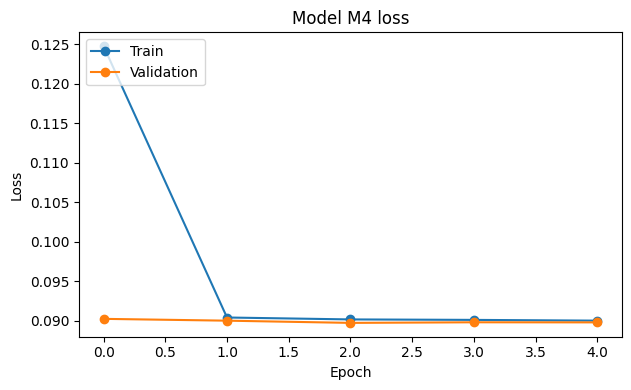

 M4 Training Loss:
[0.12473694235086441, 0.09038469940423965, 0.09014132618904114, 0.0900820940732956, 0.0899864137172699]
 M4 Validation Loss:
[0.09021284431219101, 0.08998303860425949, 0.08970282226800919, 0.08977918326854706, 0.08976728469133377]


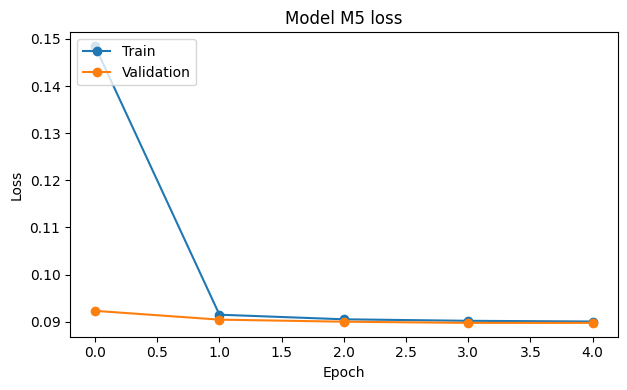

 M5 Training Loss:
[0.14845849573612213, 0.09149612486362457, 0.09051865339279175, 0.09019956737756729, 0.0900496393442154]
 M5 Validation Loss:
[0.09231468290090561, 0.09044794738292694, 0.09001035988330841, 0.0897592157125473, 0.08976101130247116]


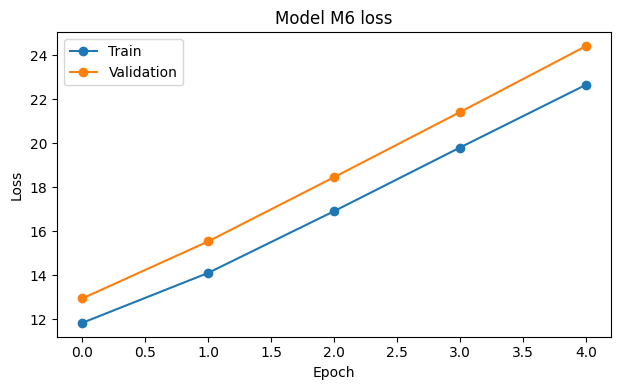

 M6 Training Loss:
[11.837037086486816, 14.106922149658203, 16.911033630371094, 19.80251693725586, 22.65140151977539]
 M6 Validation Loss:
[12.946673393249512, 15.537063598632812, 18.45549201965332, 21.41264533996582, 24.40951919555664]


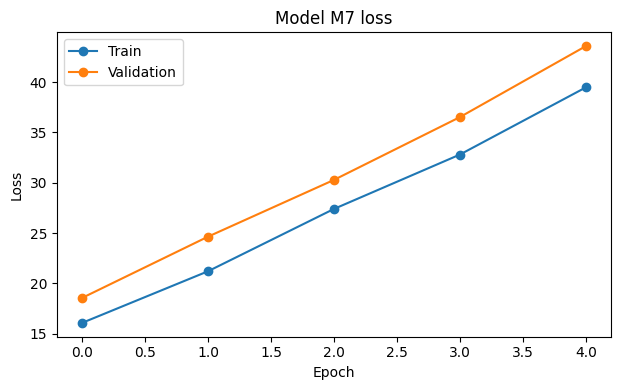

 M7 Training Loss:
[16.085996627807617, 21.21509552001953, 27.40454864501953, 32.805999755859375, 39.47658920288086]
 M7 Validation Loss:
[18.565637588500977, 24.65142822265625, 30.28894805908203, 36.52614212036133, 43.576168060302734]


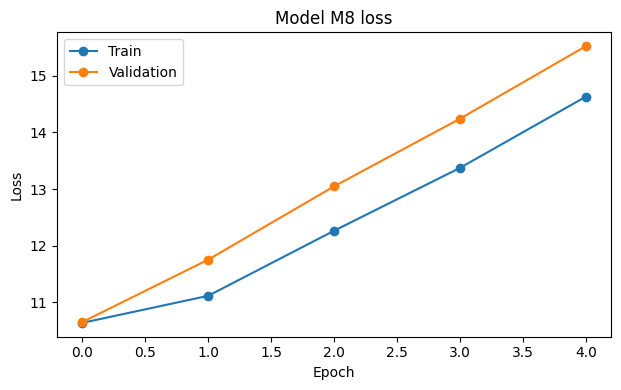

 M8 Training Loss:
[10.638192176818848, 11.115821838378906, 12.264753341674805, 13.374910354614258, 14.63244915008545]
 M8 Validation Loss:
[10.652192115783691, 11.754047393798828, 13.048377990722656, 14.242546081542969, 15.524309158325195]


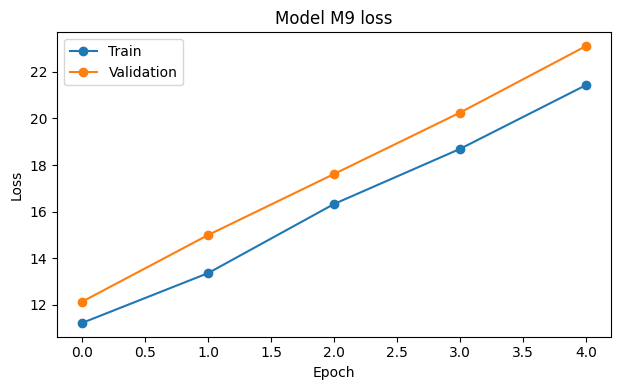

 M9 Training Loss:
[11.226788520812988, 13.362220764160156, 16.32694435119629, 18.6901798248291, 21.42518424987793]
 M9 Validation Loss:
[12.138565063476562, 14.99669361114502, 17.61425018310547, 20.24690055847168, 23.099239349365234]


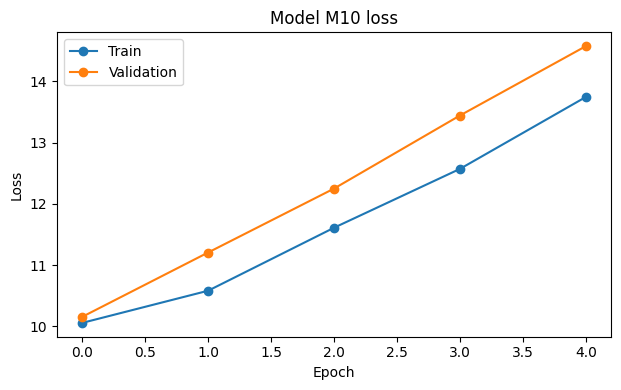

 M10 Training Loss:
[10.058412551879883, 10.583200454711914, 11.610478401184082, 12.570398330688477, 13.743398666381836]
 M10 Validation Loss:
[10.157154083251953, 11.206496238708496, 12.249246597290039, 13.441237449645996, 14.572453498840332]


In [ ]:
# Process each model
file_names = ['Trainable_history_M4', 'Trainable_history_M5', 'categorical_history_M1', 'categorical_history_M2',
              'categorical_history_M3', 'categorical_history_M4','categorical_history_M5']
model_names = ['M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']
for model_name,file_name in zip(model_names,file_names):
    history = load_model_history(file_name)
    plot_metrics_and_display_final(model_name, history)


In [ ]:
model_df=display_output_dataframe('M1')
model_df.head(20)

M1 output dataframe head:


category                                        gold_labels  \
0   tajuk utama  {"0": [true, true], "1": [false], "2": [true],...   
1       showbiz  {"0": [true], "1": [false], "2": [true], "3": ...   
2       showbiz  {"0": [true, true], "1": [true], "2": [false],...   
3     teknologi  {"0": [true, false], "1": [true, true, true], ...   
4      olahraga  {"0": [true], "1": [true, true], "2": [false, ...   
5       showbiz  {"0": [true, false], "1": [true], "2": [false,...   
6   tajuk utama  {"0": [true, true], "1": [true], "2": [false, ...   
7   tajuk utama  {"0": [true, true], "1": [true, false], "2": [...   
8   tajuk utama  {"0": [true, true], "1": [true, true], "2": [t...   
9     teknologi  {"0": [false, false], "1": [false, false], "2"...   
10      showbiz  {"0": [true, true, true], "1": [true], "2": [f...   
11      showbiz  {"0": [true, true, true], "1": [false, true, t...   
12     olahraga  {"0": [true, true], "1": [true, true, false], ...   
13    teknologi  {"0": [true, true, true], "1": [false, false, ...   
14     olahraga  {"0": [true, true], "1": [true, true], "2": [f...   
15  tajuk utama  {"0": [false], "1": [false], "2": [true], "3":...   
16    teknologi  {"0": [true, true], "1": [false, false], "2": ...   
17    inspirasi  {"0": [true, true, true], "1": [true, true, fa...   
18      hiburan  {"0": [true, true], "1": [true, true], "2": [f...   
19  tajuk utama  {"0": [true, true], "1": [false], "2": [false,...   

                                                   id  \
0   1489771800-dua-wni-lolos-hukuman-mati-di-arab-...   
1   1502417986-ibu-taylor-swift-sakit-hati-anaknya...   
2   1518811200-kanye-west-kembali-ke-instagram-fan...   
3   1512173700-startup-fintech-lending-awantunai-r...   
4   1496783700-petrucci-saya-minta-maaf-ke-valenti...   
5   1503867271-ayah-jadi-inspirasi-agnez-mo-terapk...   
6   1511252051-nazaruddin-ungkap-uang-untuk-gamawa...   
7    1502865488-india-berniat-usir-pengungsi-rohingya   
8   1499990820-pasangan-gay-muslim-di-inggris-jadi...   
9   1506464464-lunar-smartwatch-analog-bertenaga-m...   
10  1511503200-khloe-kardashian-berniat-jauhi-kame...   
11  1507654800-sooyoung-seohyun-dan-tiffany-snsd-t...   
12       1500508800-awal-yang-tak-baik-untuk-ac-milan   
13     1503781457-tiketcom-fokus-sempurnakan-aplikasi   
14     1482725452-mental-baja-anak-anak-muda-ac-milan   
15  1514711700-kronologi-penangkapan-anggota-fpi-t...   
16  1499815800-bri-segera-akuisisi-perusahaan-moda...   
17  1484946031-perjuangan-salim-harama-melukis-den...   
18  1500226200-raffi-ahmad-lupa-ulang-tahun-julia-...   
19  1502434310-first-travel-raup-untung-ratusan-mi...   

                                           paragraphs          source  \
0   {"0": ["Jakarta , CNN Indonesia - - Dua warga ...   cnn indonesia   
1   {"0": ["Jakarta , CNN Indonesia - - Ibunda Tay...   cnn indonesia   
2   {"0": ["Jakarta , CNN Indonesia - - Kanye West...   cnn indonesia   
3   {"0": ["Startup fintech yang bergerak di bidan...  dailysocial.id   
4   {"0": ["Jakarta , CNN Indonesia - - Pebalap Pr...   cnn indonesia   
5   {"0": ["Menjalani pola hidup sehat merupakan s...        kumparan   
6   {"0": ["Mantan Bendahara Umum Partai Demokrat ...        kumparan   
7   {"0": ["Merdeka.com - Nasib sekitar 40 ribu or...         merdeka   
8   {"0": ["Jakarta , CNN Indonesia - - Pasangan g...   cnn indonesia   
9   {"0": ["Sampai di tahun 2017 ini , kelemahan u...  dailysocial.id   
10  {"0": ["Jakarta , CNN Indonesia - - Khloe Kard...   cnn indonesia   
11  {"0": ["Kabar mengejutkan datang dari keluarga...        kumparan   
12  {"0": ["Kiprah AC Milan di International Champ...        kumparan   
13  {"0": ["Pasca Blibli masuk sebagai pemegang sa...  dailysocial.id   
14  {"0": ["Merdeka.com - Skuat muda AC Milan besu...         merdeka   
15  {"0": ["Jakarta , CNN Indonesia - - Kepolisian...   cnn indonesia   
16  {"0": ["Bank Rakyat Indonesia ( BRI ) segera m...  dailysocial.id   
17  {"0": ["Merdeka.com 

In [ ]:
model_df=display_output_dataframe('M2')
model_df.head(20)

M2 output dataframe head:


category                                        gold_labels  \
0   tajuk utama  {"0": [true, true], "1": [false], "2": [true],...   
1       showbiz  {"0": [true], "1": [false], "2": [true], "3": ...   
2       showbiz  {"0": [true, true], "1": [true], "2": [false],...   
3     teknologi  {"0": [true, false], "1": [true, true, true], ...   
4      olahraga  {"0": [true], "1": [true, true], "2": [false, ...   
5       showbiz  {"0": [true, false], "1": [true], "2": [false,...   
6   tajuk utama  {"0": [true, true], "1": [true], "2": [false, ...   
7   tajuk utama  {"0": [true, true], "1": [true, false], "2": [...   
8   tajuk utama  {"0": [true, true], "1": [true, true], "2": [t...   
9     teknologi  {"0": [false, false], "1": [false, false], "2"...   
10      showbiz  {"0": [true, true, true], "1": [true], "2": [f...   
11      showbiz  {"0": [true, true, true], "1": [false, true, t...   
12     olahraga  {"0": [true, true], "1": [true, true, false], ...   
13    teknologi  {"0": [true, true, true], "1": [false, false, ...   
14     olahraga  {"0": [true, true], "1": [true, true], "2": [f...   
15  tajuk utama  {"0": [false], "1": [false], "2": [true], "3":...   
16    teknologi  {"0": [true, true], "1": [false, false], "2": ...   
17    inspirasi  {"0": [true, true, true], "1": [true, true, fa...   
18      hiburan  {"0": [true, true], "1": [true, true], "2": [f...   
19  tajuk utama  {"0": [true, true], "1": [false], "2": [false,...   

                                                   id  \
0   1489771800-dua-wni-lolos-hukuman-mati-di-arab-...   
1   1502417986-ibu-taylor-swift-sakit-hati-anaknya...   
2   1518811200-kanye-west-kembali-ke-instagram-fan...   
3   1512173700-startup-fintech-lending-awantunai-r...   
4   1496783700-petrucci-saya-minta-maaf-ke-valenti...   
5   1503867271-ayah-jadi-inspirasi-agnez-mo-terapk...   
6   1511252051-nazaruddin-ungkap-uang-untuk-gamawa...   
7    1502865488-india-berniat-usir-pengungsi-rohingya   
8   1499990820-pasangan-gay-muslim-di-inggris-jadi...   
9   1506464464-lunar-smartwatch-analog-bertenaga-m...   
10  1511503200-khloe-kardashian-berniat-jauhi-kame...   
11  1507654800-sooyoung-seohyun-dan-tiffany-snsd-t...   
12       1500508800-awal-yang-tak-baik-untuk-ac-milan   
13     1503781457-tiketcom-fokus-sempurnakan-aplikasi   
14     1482725452-mental-baja-anak-anak-muda-ac-milan   
15  1514711700-kronologi-penangkapan-anggota-fpi-t...   
16  1499815800-bri-segera-akuisisi-perusahaan-moda...   
17  1484946031-perjuangan-salim-harama-melukis-den...   
18  1500226200-raffi-ahmad-lupa-ulang-tahun-julia-...   
19  1502434310-first-travel-raup-untung-ratusan-mi...   

                                           paragraphs          source  \
0   {"0": ["Jakarta , CNN Indonesia - - Dua warga ...   cnn indonesia   
1   {"0": ["Jakarta , CNN Indonesia - - Ibunda Tay...   cnn indonesia   
2   {"0": ["Jakarta , CNN Indonesia - - Kanye West...   cnn indonesia   
3   {"0": ["Startup fintech yang bergerak di bidan...  dailysocial.id   
4   {"0": ["Jakarta , CNN Indonesia - - Pebalap Pr...   cnn indonesia   
5   {"0": ["Menjalani pola hidup sehat merupakan s...        kumparan   
6   {"0": ["Mantan Bendahara Umum Partai Demokrat ...        kumparan   
7   {"0": ["Merdeka.com - Nasib sekitar 40 ribu or...         merdeka   
8   {"0": ["Jakarta , CNN Indonesia - - Pasangan g...   cnn indonesia   
9   {"0": ["Sampai di tahun 2017 ini , kelemahan u...  dailysocial.id   
10  {"0": ["Jakarta , CNN Indonesia - - Khloe Kard...   cnn indonesia   
11  {"0": ["Kabar mengejutkan datang dari keluarga...        kumparan   
12  {"0": ["Kiprah AC Milan di International Champ...        kumparan   
13  {"0": ["Pasca Blibli masuk sebagai pemegang sa...  dailysocial.id   
14  {"0": ["Merdeka.com - Skuat muda AC Milan besu...         merdeka   
15  {"0": ["Jakarta , CNN Indonesia - - Kepolisian...   cnn indonesia   
16  {"0": ["Bank Rakyat Indonesia ( BRI ) segera m...  dailysocial.id   
17  {"0": ["Merdeka.com 

In [ ]:
model_df=display_output_dataframe('M3')
model_df[['label_indices','generated_indices']].head(20)

M3 output dataframe head:


label_indices                                  generated_indices
0   [0, 1, 3, 4, 5]                   [0, 3, 7, 9, 10, 23, 24, 25, 28]
1            [0, 2]                           [0, 5, 6, 9, 10, 20, 21]
2         [0, 1, 2]                            [8, 16, 17, 18, 19, 20]
3      [0, 2, 3, 4]             [0, 7, 13, 19, 21, 23, 26, 27, 30, 31]
4         [0, 1, 2]                          [0, 8, 9, 10, 11, 14, 16]
5     [0, 2, 5, 17]                           [0, 5, 6, 9, 10, 20, 21]
6         [0, 1, 2]                    [6, 11, 17, 19, 22, 24, 25, 26]
7         [0, 1, 2]                    [6, 11, 17, 19, 22, 24, 25, 26]
8   [0, 1, 2, 3, 4]                     [0, 3, 11, 12, 13, 14, 20, 22]
9      [4, 5, 6, 7]                            [0, 13, 14, 15, 18, 19]
10  [0, 1, 2, 3, 5]                           [0, 5, 6, 9, 10, 20, 21]
11  [0, 1, 2, 4, 5]                           [0, 1, 7, 9, 13, 17, 18]
12     [0, 1, 2, 3]                   [0, 3, 4, 9, 11, 12, 13, 14, 28]
13        [0, 1, 2]                          [0, 8, 9, 10, 11, 14, 16]
14     [0, 1, 2, 3]                       [0, 1, 5, 7, 15, 19, 23, 24]
15        [2, 3, 5]                            [8, 16, 17, 18, 19, 20]
16     [0, 1, 4, 5]                       [0, 1, 5, 7, 15, 19, 23, 24]
17  [0, 1, 2, 3, 4]  [0, 5, 7, 9, 11, 15, 24, 26, 27, 30, 31, 33, 3...
18     [0, 1, 2, 3]                          [0, 8, 9, 10, 11, 14, 16]
19           [0, 1]                       [0, 1, 5, 7, 15, 19, 23, 24]

In [ ]:
model_df=display_output_dataframe('M4')
model_df[['label_indices','generated_indices']].head(20)

M4 output dataframe head:


label_indices                                  generated_indices
0   [0, 1, 3, 4, 5]                 [0, 7, 12, 13, 14, 25, 26, 27, 28]
1            [0, 2]                           [0, 4, 7, 8, 18, 19, 21]
2         [0, 1, 2]                              [0, 1, 5, 10, 12, 15]
3      [0, 2, 3, 4]              [0, 3, 5, 15, 16, 17, 18, 22, 25, 27]
4         [0, 1, 2]                           [0, 3, 6, 7, 17, 19, 23]
5     [0, 2, 5, 17]                           [0, 4, 7, 8, 18, 19, 21]
6         [0, 1, 2]                        [0, 1, 2, 3, 7, 14, 20, 23]
7         [0, 1, 2]                      [0, 3, 4, 11, 14, 20, 23, 25]
8   [0, 1, 2, 3, 4]                       [0, 2, 3, 5, 11, 19, 21, 25]
9      [4, 5, 6, 7]                              [0, 3, 9, 10, 11, 17]
10  [0, 1, 2, 3, 5]                           [0, 4, 7, 8, 18, 19, 21]
11  [0, 1, 2, 4, 5]                           [0, 2, 3, 5, 13, 16, 20]
12     [0, 1, 2, 3]                    [0, 5, 7, 8, 9, 21, 22, 23, 28]
13        [0, 1, 2]                           [0, 3, 6, 7, 17, 19, 23]
14     [0, 1, 2, 3]                       [0, 1, 2, 9, 10, 11, 12, 20]
15        [2, 3, 5]                              [0, 1, 4, 10, 11, 12]
16     [0, 1, 4, 5]                       [0, 1, 2, 9, 10, 11, 12, 20]
17  [0, 1, 2, 3, 4]  [0, 4, 9, 10, 13, 16, 21, 26, 27, 28, 35, 38, ...
18     [0, 1, 2, 3]                           [0, 3, 6, 7, 17, 19, 23]
19           [0, 1]                       [0, 1, 2, 9, 10, 11, 12, 20]

In [ ]:
model_df=display_output_dataframe('M5')
model_df[['label_indices','generated_indices']].head(20)

M5 output dataframe head:


label_indices                                  generated_indices
0   [0, 1, 3, 4, 5]                 [0, 9, 12, 15, 16, 19, 24, 27, 28]
1            [0, 2]                          [1, 2, 7, 12, 18, 20, 21]
2         [0, 1, 2]                              [2, 3, 9, 14, 16, 18]
3      [0, 2, 3, 4]             [0, 9, 10, 11, 12, 27, 28, 29, 30, 31]
4         [0, 1, 2]                            [0, 1, 4, 6, 8, 12, 15]
5     [0, 2, 5, 17]                              [0, 1, 3, 5, 6, 7, 9]
6         [0, 1, 2]                       [2, 5, 8, 9, 10, 13, 23, 24]
7         [0, 1, 2]                       [0, 2, 8, 9, 10, 13, 14, 24]
8   [0, 1, 2, 3, 4]                       [0, 1, 5, 6, 13, 15, 16, 18]
9      [4, 5, 6, 7]                              [0, 7, 9, 10, 15, 18]
10  [0, 1, 2, 3, 5]                          [0, 2, 6, 14, 17, 18, 20]
11  [0, 1, 2, 4, 5]                          [0, 2, 5, 13, 14, 17, 18]
12     [0, 1, 2, 3]                 [0, 4, 14, 15, 16, 17, 18, 19, 27]
13        [0, 1, 2]                          [0, 3, 6, 11, 15, 18, 23]
14     [0, 1, 2, 3]                       [0, 4, 5, 9, 10, 18, 19, 23]
15        [2, 3, 5]                              [2, 3, 5, 14, 16, 19]
16     [0, 1, 4, 5]                      [0, 5, 9, 11, 12, 19, 20, 24]
17  [0, 1, 2, 3, 4]  [0, 1, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20, 4...
18     [0, 1, 2, 3]                          [0, 3, 8, 15, 16, 18, 22]
19           [0, 1]                      [0, 6, 8, 10, 11, 13, 20, 23]